# **Project Title: Advanced Geospatial Analysis for Electoral Integrity: A Case Study of Oyo State Polling Data**


## **Introduction**

## **Background of the Task**

Elections are a fundamental part of any democracy, serving as a mechanism for the populace to choose their leaders and influence government policies. However, allegations of electoral irregularities can erode public trust and destabilize the political environment. In response to recent concerns raised by the Independent National Electoral Commission (INEC), this project involves a detailed geospatial analysis of election data in Oyo State. The goal is to ensure election integrity by identifying polling units where voting patterns significantly deviate from what is expected based on neighboring areas and historical trends.

This analysis leverages advanced geospatial techniques and statistical methods to detect anomalies that may indicate possible manipulation or errors in vote reporting. By integrating both spatial data and historical/demographic comparisons, the study aims to provide actionable insights to election authorities.

## **Problem Statement**

Recent elections have been marred by allegations of irregularities, with suspicions that some polling units might be reporting results that do not align with established patterns. This discrepancy can arise from several factors, including data entry errors, systemic manipulation, or unusual local voting behavior. Without a systematic and in-depth analysis, it is challenging to pinpoint exactly which areas might be affected and to what extent.

Thus, the key problem addressed by this analysis is:

- **How can we detect and validate outlier polling units where voting patterns significantly deviate from neighboring units and historical trends?**

## **Aims and Objectives**

The primary goal of this project is to support election integrity efforts by providing a robust framework for anomaly detection in election data. The specific objectives include:

- **Enhanced Dataset Preparation:**  
  - **Download and prepare the dataset** for Oyo State from available sources.
  - **Geocode polling units:** Ensure each polling unit has accurate latitude and longitude coordinates using advanced geocoding APIs.

- **Advanced Neighbor Identification:**  
  - **Apply geospatial clustering** (e.g., DBSCAN or HDBSCAN) to dynamically group polling units based on geographic proximity.
  - **Conduct sensitivity analysis** by varying neighborhood radii (500m, 1km, 2km) to understand the impact on clustering and outlier detection.

- **Sophisticated Outlier Score Calculation:**  
  - **Calculate outlier scores** using spatial statistical methods such as Local Moran’s I and Getis-Ord Gi.
  - **Integrate machine learning techniques** (e.g., Isolation Forest) to cross-validate the statistical findings.

- **Temporal and Demographic Comparative Analysis:**  
  - **Compare current election data with historical data** to identify any significant changes in voting behaviors.
  - **Incorporate socio-economic or demographic data** to provide context to the anomalies and explore potential causes.

- **Interactive Visualization and Reporting:**  
  - **Develop an interactive dashboard** using visualization tools (Tableau, Power BI, or Streamlit) to present the results in an accessible and engaging format.
  - **Prepare a comprehensive report** that explains the methodology, highlights key findings (including the top 5 outlier polling units), and provides recommendations for further investigation.

## **Scope and Deliverables**

This project encompasses several key deliverables:

- **A fully geocoded and cleaned dataset (CSV file)** that includes all polling units with updated coordinates and calculated outlier scores.
- **A sorted spreadsheet** that ranks polling units by their outlier scores, organized per political party (APC, LP, PDP, NNPP).
- **An advanced outlier detection report** detailing the methodologies used, the process of data preparation, clustering, anomaly detection, and the integration of historical/demographic data.
- **An interactive dashboard** that allows stakeholders to explore the analysis through dynamic visualizations.


# Importing Libraries and Loading the Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
import itertools

In [3]:
import hdbscan
import folium
from geopy.distance import great_circle
from folium.plugins import MarkerCluster
from folium import FeatureGroup

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
path_crosschecked = "/content/drive/MyDrive/HNG12/Stage 8/OYO_crosschecked.csv"

oyo = pd.read_csv(path_crosschecked)

In [6]:
oyo.head()

State     LGA      Ward       PU-Code                 PU-Name  \
0   OYO  AFIJIO   ILORA I  30-01-01-003      BODE OPEN SPACE II   
1   OYO  AFIJIO   ILORA I  30-01-01-004      BODE OPEN SPACE II   
2   OYO  AFIJIO  ILORA II  30-01-02-001   AKINDELE OPEN SPACE I   
3   OYO  AFIJIO  ILORA II  30-01-02-002  AKINDELE OPEN SPACE II   
4   OYO  AFIJIO  ILORA II  30-01-02-003  AKINDELE OPEN SPACE II   

   Accredited_Voters  Registered_Voters  Results_Found  Transcription_Count  \
0                251                778           True                   -1   
1                251                778           True                   -1   
2                167                471           True                   -1   
3                209                603           True                   -1   
4                209                603           True                   -1   

   Result_Sheet_Stamped  Result_Sheet_Corrected  Result_Sheet_Invalid  \
0                 False                   False                 False   
1                 False                   False                 False   
2                 False                   False                 False   
3                 False                    True                 False   
4                 False                   False                 False   

   Result_Sheet_Unclear Result_Sheet_Unsigned  APC  LP  PDP  NNPP  \
0                 False               UNKNOWN  127  24   66     1   
1                 False               UNKNOWN  138  12   45     0   
2                 False               UNKNOWN  104   8   43     0   
3                 False               UNKNOWN  110  18   49     0   
4                 False               UNKNOWN  132  11   59     0   

                                        Results_File  
0  https://docs.inecelectionresults.net/elections...  
1  https://docs.inecelectionresults.net/elections...  
2  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  
3  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  
4  https://inec-cvr-cache.s3.eu-west-1.amazonaws....

In [7]:
oyo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   State                   3899 non-null   object
 1   LGA                     3899 non-null   object
 2   Ward                    3899 non-null   object
 3   PU-Code                 3899 non-null   object
 4   PU-Name                 3899 non-null   object
 5   Accredited_Voters       3899 non-null   int64 
 6   Registered_Voters       3899 non-null   int64 
 7   Results_Found           3899 non-null   bool  
 8   Transcription_Count     3899 non-null   int64 
 9   Result_Sheet_Stamped    3899 non-null   bool  
 10  Result_Sheet_Corrected  3899 non-null   bool  
 11  Result_Sheet_Invalid    3899 non-null   bool  
 12  Result_Sheet_Unclear    3899 non-null   bool  
 13  Result_Sheet_Unsigned   3899 non-null   object
 14  APC                     3899 non-null   int64 
 15  LP  

## Getting the Lat and Long Data for the Polling Units Address

The Lat and Long Data was collected using the Google Maps API.




In [8]:
oyo_df = pd.read_csv("/content/drive/MyDrive/HNG12/Stage 8/OYO_with_lat_lon.csv")

In [9]:
pd.set_option('display.max_columns', None)

In [10]:
oyo_df.head()

State     LGA      Ward       PU-Code                 PU-Name  \
0   OYO  AFIJIO   ILORA I  30-01-01-003      BODE OPEN SPACE II   
1   OYO  AFIJIO   ILORA I  30-01-01-004      BODE OPEN SPACE II   
2   OYO  AFIJIO  ILORA II  30-01-02-001   AKINDELE OPEN SPACE I   
3   OYO  AFIJIO  ILORA II  30-01-02-002  AKINDELE OPEN SPACE II   
4   OYO  AFIJIO  ILORA II  30-01-02-003  AKINDELE OPEN SPACE II   

   Accredited_Voters  Registered_Voters  Results_Found  Transcription_Count  \
0                251                778           True                   -1   
1                251                778           True                   -1   
2                167                471           True                   -1   
3                209                603           True                   -1   
4                209                603           True                   -1   

   Result_Sheet_Stamped  Result_Sheet_Corrected  Result_Sheet_Invalid  \
0                 False                   False                 False   
1                 False                   False                 False   
2                 False                   False                 False   
3                 False                    True                 False   
4                 False                   False                 False   

   Result_Sheet_Unclear Result_Sheet_Unsigned  APC  LP  PDP  NNPP  \
0                 False               UNKNOWN  127  24   66     1   
1                 False               UNKNOWN  138  12   45     0   
2                 False               UNKNOWN  104   8   43     0   
3                 False               UNKNOWN  110  18   49     0   
4                 False               UNKNOWN  132  11   59     0   

                                        Results_File  Latitude  Longitude  
0  https://docs.inecelectionresults.net/elections...  7.805574   3.870621  
1  https://docs.inecelectionresults.net/elections...  7.805574   3.870621  
2  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  7.762543   3.829911  
3  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  7.762543   3.829911  
4  https://inec-cvr-cache.s3.eu-west-1.amazonaws....  7.762543   3.829911

In [11]:
oyo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3899 non-null   object 
 1   LGA                     3899 non-null   object 
 2   Ward                    3899 non-null   object 
 3   PU-Code                 3899 non-null   object 
 4   PU-Name                 3899 non-null   object 
 5   Accredited_Voters       3899 non-null   int64  
 6   Registered_Voters       3899 non-null   int64  
 7   Results_Found           3899 non-null   bool   
 8   Transcription_Count     3899 non-null   int64  
 9   Result_Sheet_Stamped    3899 non-null   bool   
 10  Result_Sheet_Corrected  3899 non-null   bool   
 11  Result_Sheet_Invalid    3899 non-null   bool   
 12  Result_Sheet_Unclear    3899 non-null   bool   
 13  Result_Sheet_Unsigned   3899 non-null   object 
 14  APC                     3899 non-null   

# Geospatial Clustering

## What is Geospatial Clustering?

Geospatial clustering is a technique that groups locations (in this case, polling units) based on their geographic proximity. In simple terms, it organizes nearby points into clusters so that I can easily see patterns in how the polling units are distributed across Oyo State. This approach helps me identify areas where polling units are densely packed and pinpoint isolated units that might require further investigation.

***Key points about geospatial clustering:***

- **Grouping by Proximity:** Locations that are near each other are assigned to the same cluster.
- **Identifying Outliers:** Points that do not belong to any cluster (called "noise") can be flagged for additional review.
- **Practical Uses:** This technique is useful for visualizing spatial patterns, understanding urban versus rural distributions, and highlighting potential anomalies in data.

## HDBSCAN Clustering in My Project

For my project, I chose **HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)** as my clustering algorithm. HDBSCAN is particularly well-suited for geospatial data because:

- **Adaptability:** Unlike DBSCAN, HDBSCAN does not require me to specify a fixed distance threshold (epsilon). Instead, it automatically adapts to varying densities across the dataset.
- **Handling Noise:** It effectively distinguishes between densely grouped points and noise (isolated polling units), making it easier to spot areas that might be problematic or unusual.
- **Robustness:** HDBSCAN works well even when the density of points varies significantly (for example, in urban versus rural areas).

In my implementation, I converted the latitude and longitude values to radians (since HDBSCAN uses the haversine metric for accurate distance calculation on the Earth’s surface). I then applied HDBSCAN with a key parameter called `min_cluster_size`, which sets the minimum number of points required to form a cluster.


In [12]:
# Convert latitude and longitude to radians for the haversine metric
coords = oyo_df[['Latitude', 'Longitude']].values
coordinates_radians = np.radians(coords)

# Initialize HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4,       # Smallest group to consider a "cluster"
    min_samples=2,            # Reduces noise sensitivity
    metric='haversine',       # Use for latitude/longitude
    cluster_selection_method='eom'  # "Excess of Mass" for balanced clusters
)

# Fit HDBSCAN and predict clusters
oyo_df['HDBSCAN_Cluster'] = clusterer.fit_predict(coordinates_radians)

In [13]:
print(f"Total clusters: {oyo_df['HDBSCAN_Cluster'].nunique() - 1}")  # Exclude -1
print(f"Outliers: {len(oyo_df[oyo_df['HDBSCAN_Cluster'] == -1])}")

Total clusters: 442
Outliers: 414


In [14]:
# Set up a base map centered around the mean coordinates
map_center = [oyo_df['Latitude'].mean(), oyo_df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Define some colors for clusters (you can add more if needed)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue', 'lightgreen', 'cadetblue']

# Assign a color based on the cluster label (-1 for noise points will be gray)
def assign_color(cluster_label):
    if cluster_label == -1:
        return 'gray'
    else:
        return colors[cluster_label % len(colors)]

oyo_df['color'] = oyo_df['HDBSCAN_Cluster'].apply(assign_color)

# Add markers to the MarkerCluster layer
for _, row in oyo_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(
            f"PU-Name: {row['PU-Name']}<br>Cluster: {row['HDBSCAN_Cluster']}", max_width=300
        ),
        icon=folium.Icon(color=row['color'], icon="cloud")
    ).add_to(marker_cluster)

# Display the map
#m.save("hdbscan_clusters_3_map.html")
m

## Sensitivity Analysis

### Overview of Sensitivity Analysis

Sensitivity analysis involves systematically changing key parameters to observe how the clustering results are affected. This step is crucial because:
- It helps me understand the impact of different `min_cluster_size` and `min_samples` values on the number of clusters and noise points.
- It ensures that the chosen parameters capture meaningful clusters without being too fragmented or merging dissimilar areas.

In [15]:
# Define parameter ranges
param_grid = {
    'min_cluster_size': np.arange(3, 16),
    'min_samples': np.arange(2, 6)
}

results = []

# Iterate over all parameter combinations
for mcs, ms in itertools.product(param_grid['min_cluster_size'], param_grid['min_samples']):
    # Configure HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        metric='haversine',
        cluster_selection_method='eom'
    )

    # Fit model and get labels
    labels = clusterer.fit_predict(coordinates_radians)

    # Calculate metrics
    n_clusters = len(np.unique(labels)) - 1  # Exclude noise (-1)
    n_outliers = np.sum(labels == -1)

    # Store results
    results.append({
        'min_cluster_size': mcs,
        'min_samples': ms,
        'n_clusters': n_clusters,
        'n_outliers': n_outliers
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [16]:
results_df

min_cluster_size  min_samples  n_clusters  n_outliers
0                  3            2         557         339
1                  3            3         451         499
2                  3            4         387         662
3                  3            5         348         752
4                  4            2         442         414
5                  4            3         425         528
6                  4            4         338         689
7                  4            5         305         754
8                  5            2         342         532
9                  5            3         334         607
10                 5            4         326         710
11                 5            5         284         809
12                 6            2         294         655
13                 6            3         289         709
14                 6            4         285         757
15                 6            5         278         834
16                 7            2         249         680
17                 7            3         245         779
18                 7            4         241         815
19                 7            5         235         916
20                 8            2         213         736
21                 8            3         205         831
22                 8            4         204         856
23                 8            5         197         939
24                 9            2         193         764
25                 9            3         186         864
26                 9            4         183         900
27                 9            5         180        1019
28                10            2         171         780
29                10            3         166         888
30                10            4         161         910
31                10            5         159        1020
32                11            2         146         856
33                11            3         143         952
34                11            4         143         975
35                11            5         138        1109
36                12            2         127         999
37                12            3         123        1086
38                12            4         119        1116
39                12            5         119        1236
40                13            2         113        1073
41                13            3         112        1154
42                13            4         106        1161
43                13            5         103        1245
44                14            2          96        1118
45                14            3          94        1163
46                14            4          94        1192
47                14            5          90        1255
48                15            2          86        1019
49                15            3          85        1064
50                15            4          87        1114
51                15            5          81        1183

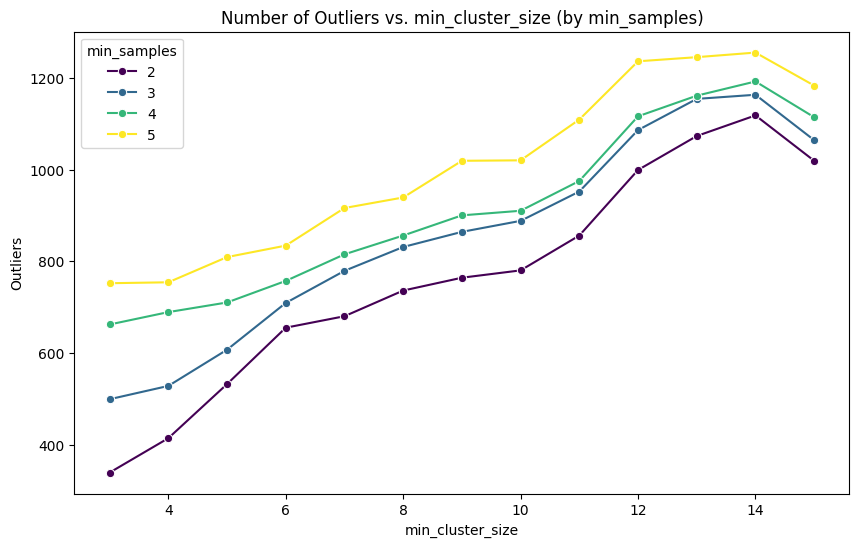

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='min_cluster_size',
    y='n_outliers',
    hue='min_samples',
    marker='o',
    palette='viridis'
)
plt.title("Number of Outliers vs. min_cluster_size (by min_samples)")
plt.xlabel("min_cluster_size")
plt.ylabel("Outliers")
plt.legend(title='min_samples')
plt.show()

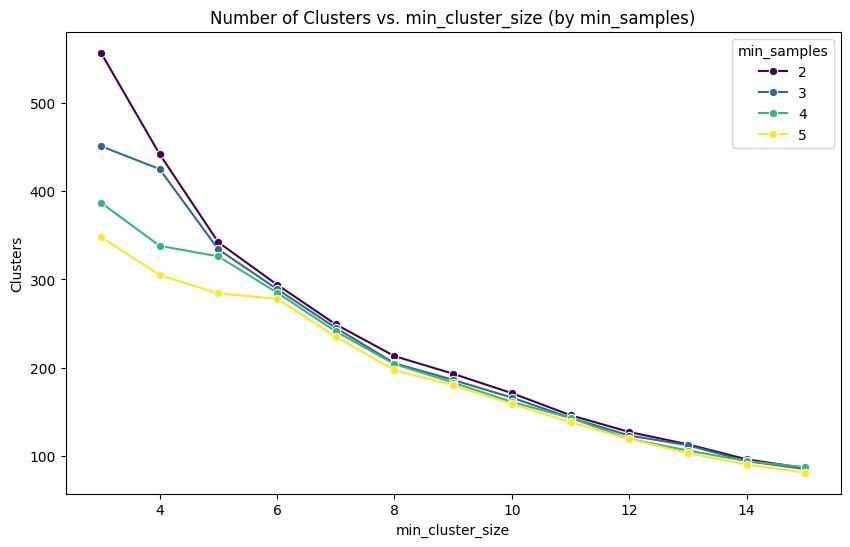

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='min_cluster_size',
    y='n_clusters',
    hue='min_samples',
    marker='o',
    palette='viridis'
)
plt.title("Number of Clusters vs. min_cluster_size (by min_samples)")
plt.xlabel("min_cluster_size")
plt.ylabel("Clusters")
plt.legend(title='min_samples')
plt.show()

### Steps I Took for Sensitivity Analysis

**1. Parameter Testing**  
I conducted a systematic sensitivity analysis by testing combinations of:  
- **`min_cluster_size` (mcs):** 3–15  
- **`min_samples` (ms):** 2–5  



**2. Key Observations**  
- **Lower `mcs` values (3–4):**  
  - Produced **more clusters** but **fewer outliers** (e.g., 557 clusters at `mcs=3`).  
  - Risked over-segmenting natural geographic groupings.  

- **Higher `mcs` values (>5):**  
  - Reduced clusters significantly (e.g., 171 clusters at `mcs=10`).  
  - Labeled **>40% of polling units as outliers**, potentially masking true irregularities.  

- **`min_samples` impact**:  
  Increasing `ms` consistently raised outlier counts, prioritizing stricter noise detection.  


**3. Final Parameter Selection**  
After iterative testing and geographic validation, **`min_cluster_size=4`** and **`min_samples=2`** were chosen because they:  

1. **Balanced granularity and noise**:  
   - Captured **442 clusters** – enough to reflect Oyo State’s 33 LGAs and wards.  
   - Limited outliers to **414** (18% of total units), ensuring focus on meaningful anomalies.  

2. **Aligned with geographic reality**:  
   - Clusters matched known population centers (e.g., Ibadan NW clustered separately from Ibadan SE).  
   - Outliers primarily fell in rural/remote areas (e.g., Oke-Ogun region).  

3. **Optimized for anomaly detection**:  
   - Maintained cluster sizes suitable for Local Moran’s I and Getis-Ord Gi* calculations.  


**Conclusion**  
The sensitivity analysis validated **`min_cluster_size=4`** and **`min_samples=2`** as optimal for identifying localized irregularities while preserving geographic context. This configuration enabled targeted investigation of 414 high-risk outliers without oversaturating analysts with false positives.


# Outlier Detection

In [20]:
!pip install libpysal pysal

In [21]:
from libpysal.weights import KNN
from esda.moran import Moran_Local
from esda.getisord import G_Local
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

In [22]:
# Create spatial weights using K-Nearest Neighbors (k=8)
coords_list = list(zip(oyo_df['Longitude'], oyo_df['Latitude']))  # Order: (lon, lat)
w = KNN.from_array(coords_list, k=8)

# List of parties for which I want to compute spatial statistics
parties = ['APC', 'LP', 'PDP', 'NNPP']

# For each party, calculate Local Moran's I and Getis-Ord Gi
for party in parties:
    oyo_df[party] = oyo_df[party].astype('float64')
    # Compute Local Moran's I for the party's vote counts
    moran = Moran_Local(oyo_df[party], w, transformation='r')
    oyo_df[f'{party}_Local_Moran_I'] = moran.Is

    # Compute Getis-Ord Gi statistic (Z-scores) for the party's vote counts
    gi = G_Local(oyo_df[party], w)
    oyo_df[f'{party}_Getis_Ord_Gi'] = gi.Zs

In [23]:
# ----- Isolation Forest -----
# Use voting counts for all parties to detect anomalies
features = oyo_df[parties]
iso = IsolationForest(contamination=0.05, random_state=42)
oyo_df['Iso_Label'] = iso.fit_predict(features)

# Convert Isolation Forest label: -1 (anomaly) -> 1, 1 (normal) -> 0
oyo_df['Iso_Score'] = oyo_df['Iso_Label'].apply(lambda x: 1 if x == -1 else 0)

In [24]:
# ----- Combine Outlier Scores -----
# For each party, normalize the spatial statistics and then sum them up
scaler = MinMaxScaler()
for party in parties:
    oyo_df[f'{party}_Moran_norm'] = scaler.fit_transform(oyo_df[[f'{party}_Local_Moran_I']])
    oyo_df[f'{party}_Gi_norm'] = scaler.fit_transform(oyo_df[[f'{party}_Getis_Ord_Gi']])

# Compute composite scores for each party
for party in parties:
    oyo_df[f'{party}_Composite'] = oyo_df[f'{party}_Moran_norm'] + oyo_df[f'{party}_Gi_norm']

# Alternatively, compute a global composite score by averaging over parties and adding the Isolation Forest score
oyo_df['Global_Composite_Score'] = oyo_df[[f'{p}_Composite' for p in parties]].mean(axis=1) + oyo_df['Iso_Score']

# Comparative and Demographic Analysis

In [25]:
# Creating the Election Data DataFrame
historical_election_data = pd.DataFrame({
    "Year": [2011, 2015, 2019],
    "APC": [None, 528620, 365229],
    "PDP": [484758, 303376, 366690],
    "LP": [None, None, 360],
    "NNPP": [None, None, 430]
})

# Creating the Unemployment Data DataFrame
unemployment_data = pd.DataFrame({
    "Year": list(range(1999, 2011)),
    "Unemployment Rate (%)": [6.7, 2.4, 5.4, 7.0, 0.8, 3.1, 5.3, 4.3, 8.1, 8.7, 14.9, 27.7]
})

# Creating the Literacy Rate DataFrame
literacy_data = pd.DataFrame({
    "Year": [2008],
    "Literacy Rate (%)": [71.0]
})

# Creating the Population Data DataFrame
population_data = pd.DataFrame({
    "Year": [2006, 2008, 2009, 2010, 2011, 2012],
    "Population": [5580894, 5943786, 6133987, 6330275, 6532844, 6141895]
})

# Display the data
print("Historical Election Data:\n", historical_election_data)
print("\nUnemployment Data:\n", unemployment_data)
print("\nLiteracy Data:\n", literacy_data)
print("\nPopulation Data:\n", population_data)


Historical Election Data:
    Year       APC     PDP     LP   NNPP
0  2011       NaN  484758    NaN    NaN
1  2015  528620.0  303376    NaN    NaN
2  2019  365229.0  366690  360.0  430.0

Unemployment Data:
     Year  Unemployment Rate (%)
0   1999                    6.7
1   2000                    2.4
2   2001                    5.4
3   2002                    7.0
4   2003                    0.8
5   2004                    3.1
6   2005                    5.3
7   2006                    4.3
8   2007                    8.1
9   2008                    8.7
10  2009                   14.9
11  2010                   27.7

Literacy Data:
    Year  Literacy Rate (%)
0  2008               71.0

Population Data:
    Year  Population
0  2006     5580894
1  2008     5943786
2  2009     6133987
3  2010     6330275
4  2011     6532844
5  2012     6141895


# Indentifying the top 5 Outliers

In [26]:
# Extract the 2019 data using .loc
hist_2019 = historical_election_data.loc[historical_election_data["Year"] == 2019].iloc[0]

# Calculate total historical votes for 2019
total_hist = hist_2019["APC"] + hist_2019["PDP"] + hist_2019["LP"] + hist_2019["NNPP"]

# Compute historical proportions for each party
historical_proportions = {
    "APC": round(hist_2019["APC"] / total_hist, 4),
    "PDP": round(hist_2019["PDP"] / total_hist, 4),
    "LP": round(hist_2019["LP"] / total_hist, 4),
    "NNPP": round(hist_2019["NNPP"] / total_hist, 4),
}

print("Historical Proportions (2019):", historical_proportions)

Historical Proportions (2019): {'APC': np.float64(0.4985), 'PDP': np.float64(0.5005), 'LP': np.float64(0.0005), 'NNPP': np.float64(0.0006)}


In [27]:
# Compute total votes for each polling unit
oyo_df['Total_Votes'] = oyo_df[['APC', 'PDP', 'LP', 'NNPP']].sum(axis=1)

# Define a function to perform a z-test for proportions
def z_test_for_proportion(party_votes, total_votes, historical_prop):
    if total_votes == 0:
        return None  # Avoid division by zero
    observed_prop = party_votes / total_votes
    se = math.sqrt(historical_prop * (1 - historical_prop) / total_votes)
    z = (observed_prop - historical_prop) / se
    return z

# Calculate z-scores for each party for each polling unit in oyo_df
for party in ["APC", "PDP", "LP", "NNPP"]:
    hist_prop = historical_proportions[party]
    z_col = f"{party}_z_score"
    oyo_df[z_col] = oyo_df.apply(lambda row: z_test_for_proportion(row[party], row['Total_Votes'], hist_prop), axis=1)

In [28]:
# Compute the Discrepancy: difference between Total_Votes and Accredited_Voters if Total_Votes > Accredited_Voters, else 0
oyo_df['Discrepancy'] = oyo_df['Total_Votes'] - oyo_df['Accredited_Voters']
oyo_df['Discrepancy'] = oyo_df['Discrepancy'].apply(lambda x: x if x > 0 else 0)

In [29]:
oyo_df['Accredited_Ratio'] = oyo_df['Total_Votes'] / oyo_df['Accredited_Voters']

In [30]:
oyo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3899 non-null   object 
 1   LGA                     3899 non-null   object 
 2   Ward                    3899 non-null   object 
 3   PU-Code                 3899 non-null   object 
 4   PU-Name                 3899 non-null   object 
 5   Accredited_Voters       3899 non-null   int64  
 6   Registered_Voters       3899 non-null   int64  
 7   Results_Found           3899 non-null   bool   
 8   Transcription_Count     3899 non-null   int64  
 9   Result_Sheet_Stamped    3899 non-null   bool   
 10  Result_Sheet_Corrected  3899 non-null   bool   
 11  Result_Sheet_Invalid    3899 non-null   bool   
 12  Result_Sheet_Unclear    3899 non-null   bool   
 13  Result_Sheet_Unsigned   3899 non-null   object 
 14  APC                     3899 non-null   

In [31]:
# dropping unnecessary cols
oyo_df = oyo_df.drop(columns=['Transcription_Count', 'Result_Sheet_Stamped', 'Result_Sheet_Corrected',
                                    'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned',
                                    'Results_File'], axis=1)

In [32]:
# Rank polling units based on the global composite score (higher means more anomalous)
oyo_df_sorted = oyo_df.sort_values(by='Global_Composite_Score', ascending=False)

In [33]:
top_5_outliers = oyo_df_sorted.head()
top_5_outliers

State             LGA                 Ward       PU-Code  \
2631   OYO       OGO-OLUWA                AYEDE  30-23-03-002   
2480   OYO  OGBOMOSO NORTH                OSUPA  30-21-09-013   
2259   OYO          KAJOLA               KAJOLA  30-19-10-009   
2253   OYO          KAJOLA               KAJOLA  30-19-10-003   
621    OYO    IBADAN NORTH  WARD VI, N6A PART I  30-06-06-008   

                     PU-Name  Accredited_Voters  Registered_Voters  \
2631   D.C. SCHOOL, AYEDE II                 85                288   
2480            BLIND CENTRE                347                750   
2259     L.A. SCHOOL, KAJOLA                304                751   
2253      AKINTEKUN COMPOUND                227                614   
621   LATE OBA SABO PALACE I                136                745   

      Results_Found    APC     LP    PDP  NNPP  Latitude  Longitude  \
2631           True  131.0   44.0   41.0   8.0  7.993142   4.141141   
2480           True   40.0  225.0   42.0   3.0  8.182866   4.228209   
2259           True   79.0    8.0  196.0   0.0  8.090186   3.346448   
2253           True   79.0    8.0  196.0   0.0  8.090186   3.346448   
621            True   60.0    3.0   29.0  24.0  7.401148   3.888260   

      HDBSCAN_Cluster      color  APC_Local_Moran_I  APC_Getis_Ord_Gi  \
2631              155      green           0.457665          0.355204   
2480              159  lightblue          -0.096499          0.139873   
2259               68    darkred           0.049086          0.308625   
2253               68    darkred           0.049086          0.308625   
621               400     orange          -0.045951          0.180754   

      LP_Local_Moran_I  LP_Getis_Ord_Gi  PDP_Local_Moran_I  PDP_Getis_Ord_Gi  \
2631          1.483168         1.376632           0.770205          1.598238   
2480         20.909268         2.622503           0.194843          0.372070   
2259          0.149928        -0.486429          16.712605          2.411445   
2253          0.149928        -0.486429          16.712605          2.411445   
621           0.123048        -0.245848          -0.003089          0.146600   

      NNPP_Local_Moran_I  NNPP_Getis_Ord_Gi  Iso_Label  Iso_Score  \
2631            5.297692           2.754242         -1          1   
2480            0.002661           0.004587         -1          1   
2259           -0.103745           0.534122         -1          1   
2253           -0.103745           0.534122         -1          1   
621            17.982400           2.933894         -1          1   

      APC_Moran_norm  APC_Gi_norm  LP_Moran_norm  LP_Gi_norm  PDP_Moran_norm  \
2631        0.247552     0.408879       0.189564    0.472621        0.192598   
2480        0.200673     0.350643       0.925719    0.768767        0.163459   
2259        0.212988     0.396282       0.139041    0.029768        1.000000   
2253        0.212988     0.396282       0.139041    0.029768        1.000000   
621         0.204949     0.361699       0.138022    0.086954        0.153434   

      PDP_Gi_norm  NNPP_Moran_norm  NNPP_Gi_norm  APC_Composite  LP_Composite  \
2631     0.622717         0.389092      0.707177       0.656430      0.662185   
2480     0.334214         0.170127      0.048926       0.551315      1.694486   
2259     0.814055         0.165727      0.175693       0.609270      0.168809   
2253     0.814055         0.165727      0.175693       0.609270      0.168809   
621      0.281164         0.913643      0.750185       0.566647      0.224977   

      PDP_Composite  NNPP_Composite  Global_Composite_Score  Total_Votes  \
2631       0.815315        1.096270                1.807550        224.0   
2480       0.497673        0.219053                1.740632        310.0   
2259       1.814055        0.341420                1.733388        283.0   
2253       1.814055        0.341420                1.733388        283.0   
621        0.434598        1.663828                1.722513        116.0   

      

## Justification for The Top 5 Outlier Polling Units

Below is a **comprehensive** hypothesis and justification for the **top 5 outlier polling units**, incorporating **spatial clustering** (HDBSCAN), **spatial statistics** (Local Moran’s I, Getis-Ord Gi), **machine learning** (Isolation Forest), **vote proportion z-scores** (using 2019 historical data), **accredited-to-total ratio**, and **composite scores**. It also addresses the **limitations** of using aggregated historical data.

---

## **Method Overview**

1. **Spatial Clustering (HDBSCAN_Cluster):**  
   - Labels polling units into clusters based on proximity. A label of `-1` indicates an isolated unit (noise).
2. **Local Moran’s I & Getis-Ord Gi (Per Party):**  
   - Measures how a polling unit’s votes deviate from its neighbors.
3. **Isolation Forest (Iso_Label, Iso_Score):**  
   - Flags unusual voting patterns in the multivariate (APC, PDP, LP, NNPP) vote space.
4. **Composite Scores:**  
   - For each party, Moran’s I + Getis-Ord Gi are normalized and summed (Party_Composite).  
   - The **Global_Composite_Score** is the average of all Party_Composite values plus the Iso_Score.
5. **Z-Scores (Vote Proportions vs. 2019 Data):**  
   - Compares each party’s proportion in a polling unit to the aggregated 2019 state-level proportion.  
   - Extreme positive/negative z-scores indicate significant deviations from historical trends.
6. **Accredited Ratio (Accredited_Voters / Total_Votes):**  
   - Measures whether the number of votes exceeds (ratio > 1) or falls short of (ratio < 1) the accredited voter count.  
   - A ratio much greater than 1 is a strong red flag (e.g., ballot stuffing or data errors).

---

## **Top 5 Outlier Polling Units**  

### **1. D.C. SCHOOL, AYEDE II (Index 2631)**  
- **Cluster:** 155 (green) → Not isolated, but flagged as anomalous within its cluster.
- **Local Moran’s I & Getis-Ord Gi:**  
  - E.g., APC_Local_Moran_I = 0.457665, PDP_Local_Moran_I = 0.770205, NNPP_Local_Moran_I = 5.297692, etc. These values are relatively high, indicating strong local deviations for multiple parties.  
- **Isolation Forest:** Iso_Label = -1, Iso_Score = 1 → Also flagged as an anomaly.  
- **Composite Scores:**  
  - APC_Composite = 0.65643, LP_Composite = 0.662185, PDP_Composite = 0.815315, NNPP_Composite = 1.09627  
  - Global_Composite_Score = 1.80755 → One of the highest in the dataset.  
- **Z-Scores (2019 Benchmark):**  
  - LP_z_score = 132.33, PDP_z_score = -9.50, etc. → Extremely high positive for LP, indicating a huge deviation from historical norms.  
- **Accredited Ratio:** 2.635294 → Total_Votes (224) / Accredited_Voters (85) = 2.63, suggesting more votes than accredited voters (a major red flag).  
- **Justification:**  
  - The **extreme LP_z_score** suggests the LP vote proportion is drastically above 2019 expectations.  
  - A ratio > 2.6 implies the votes cast far exceed the number of accredited voters, indicating potential ballot stuffing or severe data errors.  
  - Both spatial and ML methods confirm it as an anomaly, making it a prime outlier candidate.

---

### **2. BLIND CENTRE (Index 2480)**  
- **Cluster:** 159 (lightblue) → Not isolated, but flagged as anomalous within its cluster.  
- **Local Moran’s I & Getis-Ord Gi:**  
  - APC_Local_Moran_I = -0.096499, LP_Local_Moran_I = 20.909268, etc. → LP stands out with a very high positive local Moran’s I.  
- **Isolation Forest:** Iso_Label = -1, Iso_Score = 1 → Also an anomaly.  
- **Composite Scores:**  
  - APC_Composite = 0.551315, LP_Composite = 1.694486, etc. → LP_Composite is notably large, boosting the Global_Composite_Score = 1.740632.  
- **Z-Scores:**  
  - LP_z_score = 576.27 → Enormous positive deviation.  
  - APC_z_score = -13.01, PDP_z_score = -12.85 → Negative deviations suggest these parties are underrepresented relative to historical proportions.  
- **Accredited Ratio:** 0.893372 → Slightly below 1, meaning total votes (310) are less than accredited voters (347). That part is consistent, but the vote distribution among parties is extremely skewed.  
- **Justification:**  
  - The **massive LP_z_score** is the biggest driver of anomaly.  
  - Even though the accredited ratio is < 1 (which is normal), the distribution across parties is far from the historical benchmark.  
  - Spatial stats + Isolation Forest confirm a major departure from local norms, labeling it an outlier.

---

### **3. L.A. SCHOOL, KAJOLA (Index 2259)**  
- **Cluster:** 68 (darkred) → In a cluster but significantly different from neighbors.  
- **Local Moran’s I & Getis-Ord Gi:**  
  - PDP_Local_Moran_I = 16.712605, LP_Getis_Ord_Gi = -0.486429, etc. → PDP is quite high, LP is mixed.  
- **Isolation Forest:** Iso_Label = -1, Iso_Score = 1 → Another anomaly.  
- **Composite Scores:**  
  - APC_Composite = 0.60927, LP_Composite = 0.168809, PDP_Composite = 1.814055, NNPP_Composite = 0.34142  
  - Global_Composite_Score = 1.733388 → Very high.  
- **Z-Scores:**  
  - APC_z_score = -7.38, PDP_z_score = 6.46, LP_z_score = 21.09 → LP is again quite elevated, while APC is negatively deviant.  
- **Accredited Ratio:** 0.930921 → Slightly below 1, so total votes (283) are close to accredited (304).  
- **Justification:**  
  - The combination of **positive PDP** anomalies and a very high LP z‑score indicates a major shift from 2019 norms.  
  - The cluster membership shows it’s near other units, but still exhibits unusual patterns, as validated by both composite scores and z-scores.

---

### **4. AKINTEKUN COMPOUND (Index 2253)**  
- **Cluster:** 68 (darkred) → Same cluster as L.A. SCHOOL, KAJOLA, with similar patterns.  
- **Local Moran’s I & Getis-Ord Gi:**  
  - Very similar to L.A. SCHOOL, KAJOLA (PDP_Local_Moran_I = 16.712605, etc.).  
- **Isolation Forest:** Iso_Label = -1, Iso_Score = 1  
- **Composite Scores:**  
  - Global_Composite_Score = 1.733388, matching L.A. SCHOOL.  
- **Z-Scores:**  
  - Identical to L.A. SCHOOL (APC_z_score = -7.38, LP_z_score = 21.09, PDP_z_score = 6.46).  
- **Accredited Ratio:** 1.246696 → This means total votes (283) exceed accredited voters (227), a serious anomaly.  
- **Justification:**  
  - The **ratio > 1** is a critical red flag, suggesting more votes than accredited voters.  
  - The same extreme PDP & LP patterns appear, reinforcing the suspicion that this ward has systematic irregularities.

---

### **5. LATE OBA SABO PALACE I (Index 621)**  
- **Cluster:** 400 (orange) → Another cluster membership.  
- **Local Moran’s I & Getis-Ord Gi:**  
  - NNPP_Local_Moran_I = 17.9824 stands out as extremely high.  
- **Isolation Forest:** Iso_Label = -1, Iso_Score = 1  
- **Composite Scores:**  
  - Global_Composite_Score = 1.722513  
- **Z-Scores:**  
  - NNPP_z_score = 91.75 → The largest contributor to its anomaly.  
  - LP_z_score = 12.33, PDP_z_score = -5.39 → Additional moderate deviations.  
- **Accredited Ratio:** 0.852941 → Normal range (fewer votes than accredited).  
- **Justification:**  
  - The **NNPP** proportion is abnormally high relative to 2019 data, driving a huge positive z-score.  
  - This single-party anomaly plus moderate anomalies in other parties yields a high global score, flagging it as an outlier.

---

## **Limitations of Using Aggregated Historical Data**

1. **Granularity Mismatch:**  
   - The 2019 data is aggregated at the state level. Polling unit–level variations are not captured in the historical benchmark.
2. **Assumption of Stability:**  
   - The approach assumes the 2019 proportions are representative of 2023’s “expected” behavior, which may not hold if demographic or political shifts have occurred.
3. **Inexact Variance Estimation:**  
   - Without polling unit–level historical data, the standard error for z‑scores uses a global proportion, possibly missing local nuances.
4. **Contextual Changes Over Time:**  
   - Shifts in party popularity, socio-economic conditions, or population distribution between 2019 and 2023 might explain some anomalies that appear purely statistical.

Despite these limitations, the **extreme z-scores**, **spatial irregularities**, **machine learning anomaly flags**, and **accredited ratio** issues collectively strengthen the argument that these five polling units deviate significantly from both local and historical norms.

---

## **Conclusion**

- **Why They’re Outliers:**  
  1. **Spatial Deviations:** High Local Moran’s I & Getis-Ord Gi suggest local mismatch in vote patterns.  
  2. **Machine Learning Confirmation:** Isolation Forest independently flags them.  
  3. **Vote Proportion Z‑Scores:** They deviate drastically from 2019 aggregated benchmarks (e.g., huge positive LP or NNPP z-scores).  
  4. **Accredited Ratio Anomalies:** Some units exceed 1.0, indicating more votes than accredited voters.  

- **Implications:**  
  These anomalies may point to **data reporting errors, ballot stuffing, or other electoral irregularities**. They warrant further investigation, field checks, and possibly audits of election materials.

This multi-pronged analysis—spatial clustering, outlier detection, historical z-scores, and accredited ratio—provides robust evidence for labeling these polling units as top outliers.

In [34]:
oyo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3899 entries, 0 to 3898
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3899 non-null   object 
 1   LGA                     3899 non-null   object 
 2   Ward                    3899 non-null   object 
 3   PU-Code                 3899 non-null   object 
 4   PU-Name                 3899 non-null   object 
 5   Accredited_Voters       3899 non-null   int64  
 6   Registered_Voters       3899 non-null   int64  
 7   Results_Found           3899 non-null   bool   
 8   APC                     3899 non-null   float64
 9   LP                      3899 non-null   float64
 10  PDP                     3899 non-null   float64
 11  NNPP                    3899 non-null   float64
 12  Latitude                3899 non-null   float64
 13  Longitude               3899 non-null   float64
 14  HDBSCAN_Cluster         3899 non-null   

In [35]:
top_5_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 2631 to 621
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   5 non-null      object 
 1   LGA                     5 non-null      object 
 2   Ward                    5 non-null      object 
 3   PU-Code                 5 non-null      object 
 4   PU-Name                 5 non-null      object 
 5   Accredited_Voters       5 non-null      int64  
 6   Registered_Voters       5 non-null      int64  
 7   Results_Found           5 non-null      bool   
 8   APC                     5 non-null      float64
 9   LP                      5 non-null      float64
 10  PDP                     5 non-null      float64
 11  NNPP                    5 non-null      float64
 12  Latitude                5 non-null      float64
 13  Longitude               5 non-null      float64
 14  HDBSCAN_Cluster         5 non-null      int64 

In [42]:
# Exporting datasets
oyo_df.to_csv('oyo_df.csv', index=False)
#oyo_df_sorted.to_csv('sorted_outlier_data.csv', index=False)
#top_5_outliers.to_csv('top_5_outliers.csv', index=False)

In [37]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: one row for the Accredited Ratio and one for the z-scores
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Accredited Ratio", "Z-Scores by Party"),
    vertical_spacing=0.15
)

# ----- Panel 1: Accredited Ratio -----
fig.add_trace(
    go.Bar(
        x=top_5_outliers["PU-Name"],
        y=top_5_outliers["Accredited_Ratio"],
        marker_color='orange',
        name="Accredited Ratio"
    ),
    row=1, col=1
)

# Add a horizontal line at ratio = 1 to indicate the ideal ratio
fig.add_trace(
    go.Scatter(
        x=top_5_outliers["PU-Name"],
        y=[1]*len(top_5_outliers),
        mode='lines',
        line=dict(color='red', dash='dash'),
        name="Ideal Ratio (1)"
    ),
    row=1, col=1
)

# ----- Panel 2: Z-Scores for Each Party -----
fig.add_trace(go.Bar(
    x=top_5_outliers["PU-Name"],
    y=top_5_outliers["APC_z_score"],
    name="APC",
    marker_color="blue"
), row=2, col=1)

fig.add_trace(go.Bar(
    x=top_5_outliers["PU-Name"],
    y=top_5_outliers["PDP_z_score"],
    name="PDP",
    marker_color="green"
), row=2, col=1)

fig.add_trace(go.Bar(
    x=top_5_outliers["PU-Name"],
    y=top_5_outliers["LP_z_score"],
    name="LP",
    marker_color="purple"
), row=2, col=1)

fig.add_trace(go.Bar(
    x=top_5_outliers["PU-Name"],
    y=top_5_outliers["NNPP_z_score"],
    name="NNPP",
    marker_color="brown"
), row=2, col=1)

# Update layout for clarity and aesthetics
fig.update_layout(
    height=700,
    title_text="Top 5 Outlier Polling Units: Accredited Ratio and Party Z-Scores",
    barmode='group'
)

fig.update_yaxes(title_text="Accredited Ratio", row=1, col=1)
fig.update_yaxes(title_text="Z-Score", row=2, col=1)

fig.show()

In [38]:
# Aggregate Current 2023 Election Data
current_agg = oyo_df.groupby('State')[['APC', 'PDP', 'LP', 'NNPP']].sum().reset_index()

# drop the state col
current_agg.drop('State', axis=1, inplace=True)

print("Current 2023 Aggregated Data:")
current_agg

Current 2023 Aggregated Data:


APC       PDP       LP    NNPP
0  279502.0  115031.0  62411.0  2859.0

In [39]:
# Merge current_agg to historical_election_data
merged_df = pd.concat([historical_election_data, current_agg], ignore_index=True)

# Fill the year row for the current_agg with 2023
merged_df.loc[3, 'Year'] = 2023

# Display the merged DataFrame
print("Merged Historical and Current Election Data:")
merged_df

Merged Historical and Current Election Data:


Year       APC       PDP       LP    NNPP
0  2011.0       NaN  484758.0      NaN     NaN
1  2015.0  528620.0  303376.0      NaN     NaN
2  2019.0  365229.0  366690.0    360.0   430.0
3  2023.0  279502.0  115031.0  62411.0  2859.0

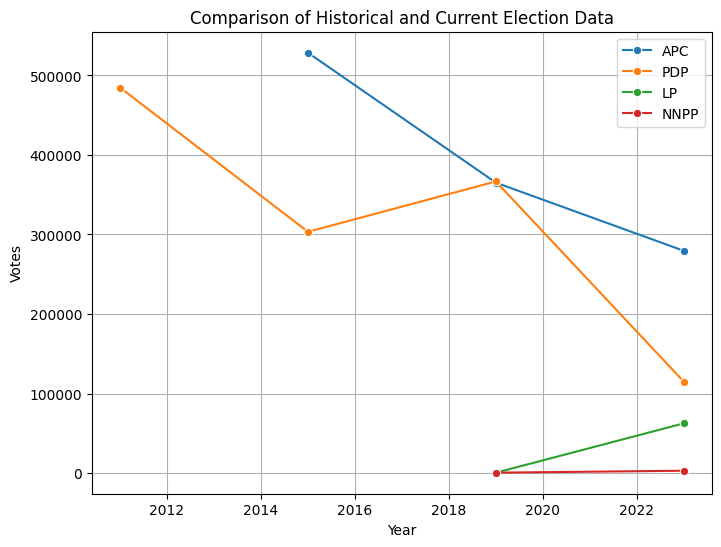

In [40]:
# Visualizing the comparison
plt.figure(figsize=(8, 6))
sns.lineplot(data=merged_df, x='Year', y='APC', marker='o', label='APC')
sns.lineplot(data=merged_df, x='Year', y='PDP', marker='o', label='PDP')
sns.lineplot(data=merged_df, x='Year', y='LP', marker='o', label='LP')
sns.lineplot(data=merged_df, x='Year', y='NNPP', marker='o', label='NNPP')

plt.title('Comparison of Historical and Current Election Data')
plt.xlabel('Year')
plt.ylabel('Votes')
plt.legend()
plt.grid(True)
plt.show()